In [19]:
# Imports y configuración inicial
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RANDOM_STATE = 42
# Rutas (relativas al notebook)
ROOT = Path('..')
DATA_RAW = ROOT / 'data' / 'processed' / 'segmento1_csv'
FIGURES = ROOT / 'figures'
MODELS = ROOT / 'models'
# crear carpetas si no existen
FIGURES.mkdir(parents=True, exist_ok=True)
MODELS.mkdir(parents=True, exist_ok=True)

csv_path = DATA_RAW / 'cooperativas_segmento1_completo_final.csv'
print('Leyendo:', csv_path)
df = pd.read_csv(csv_path)
print('Shape:', df.shape)
# columnas importantes (ajusta según tu dataset)
candidates = ['rating','Rating','calificacion','clasificacion']
rating_col = next((c for c in candidates if c in df.columns), None)
print('Rating column detected:', rating_col)
if rating_col is not None:
    print(df[rating_col].value_counts(dropna=False))
# guardar muestra para inspección rápida
sample_out = FIGURES / 'sample_head.csv'
df.sample(min(50, len(df)), random_state=RANDOM_STATE).to_csv(sample_out, index=False)
print('Sample guardado en', sample_out)

Leyendo: ../data/processed/segmento1_csv/cooperativas_segmento1_completo_final.csv
Shape: (42, 46)
Rating column detected: None
Sample guardado en ../figures/sample_head.csv


In [20]:
# Función para detectar columnas numéricas de forma robusta
def detect_numeric_cols(df, min_non_na=5):
    cols = []
    for c in df.columns:
        try:
            cnt = pd.to_numeric(df[c], errors='coerce').notna().sum()
            if cnt >= min_non_na:
                cols.append(c)
        except Exception:
            continue
    return cols

numeric_cols = detect_numeric_cols(df)
print('Detected numeric cols (count):', len(numeric_cols))
print(numeric_cols[:30])

Detected numeric cols (count): 42
['RANKING', '( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS', 'ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO', 'MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO', 'MOROSIDAD DE LA CARTERA DE CONSUMO', 'MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO', 'MOROSIDAD DE LA CARTERA DE MICROCREDITO', 'MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO', 'MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO', 'MOROSIDAD DE LA CARTERA TOTAL', 'COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO', 'COBERTURA DE LA CARTERA DE CREDITO CONSUMO', 'COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO', 'COBERTURA DE LA CARTERA DE MICROCREDITO', 'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO', 'COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO', 'COBERTURA DE LA CARTERA PROBLEMÁTICA', 'GASTOS DE OPERACION ESTIMADOS / TOTAL ACTIVO PROMEDIO ', 'GASTOS DE OPERACION  / MARGEN FINANCIERO', 'GA

Nulos por columna guardado en ../figures/nulos_por_columna.csv


Series([], dtype: float64)

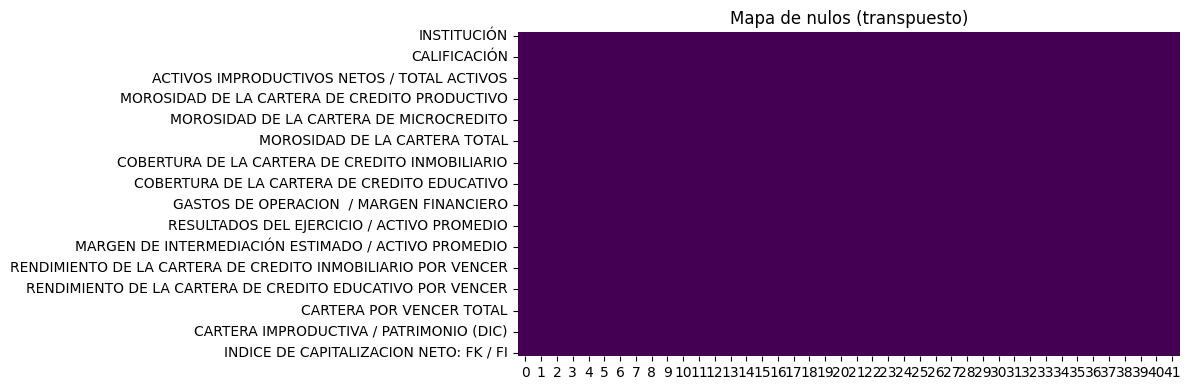

In [21]:
# 1) Análisis de nulos por columna y heatmap simple
na_pct = df.isna().mean().sort_values(ascending=False) * 100
na_out = FIGURES / 'nulos_por_columna.csv'
na_pct.reset_index().rename(columns={'index':'column', 0:'pct_na'}).to_csv(na_out, index=False)
print('Nulos por columna guardado en', na_out)
display(na_pct[na_pct>0].round(3))

# heatmap de nulos (puede ser costoso si hay muchas filas)
plt.figure(figsize=(12,4))
sns.heatmap(df.isna().T, cbar=False, cmap='viridis')
plt.title('Mapa de nulos (transpuesto)')
plt.tight_layout()
plt.savefig(FIGURES / 'nulos_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

High correlation pairs saved to ../figures/high_corr_pairs.csv


MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO              COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO    1.000000
ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS                                          FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES)         1.000000
ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS                                  FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES)         1.000000
MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO                                 COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO               1.000000
ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS                                  ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS                        1.000000
FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES  INDICE DE CAPITALIZACION NETO: FK / FI                     0.987701
GASTOS DE OPERACION  / MARGEN FINANCIERO                                     MARGEN DE INTERMEDIACIÓN ESTIMADO / PATRIMONIO PROMED

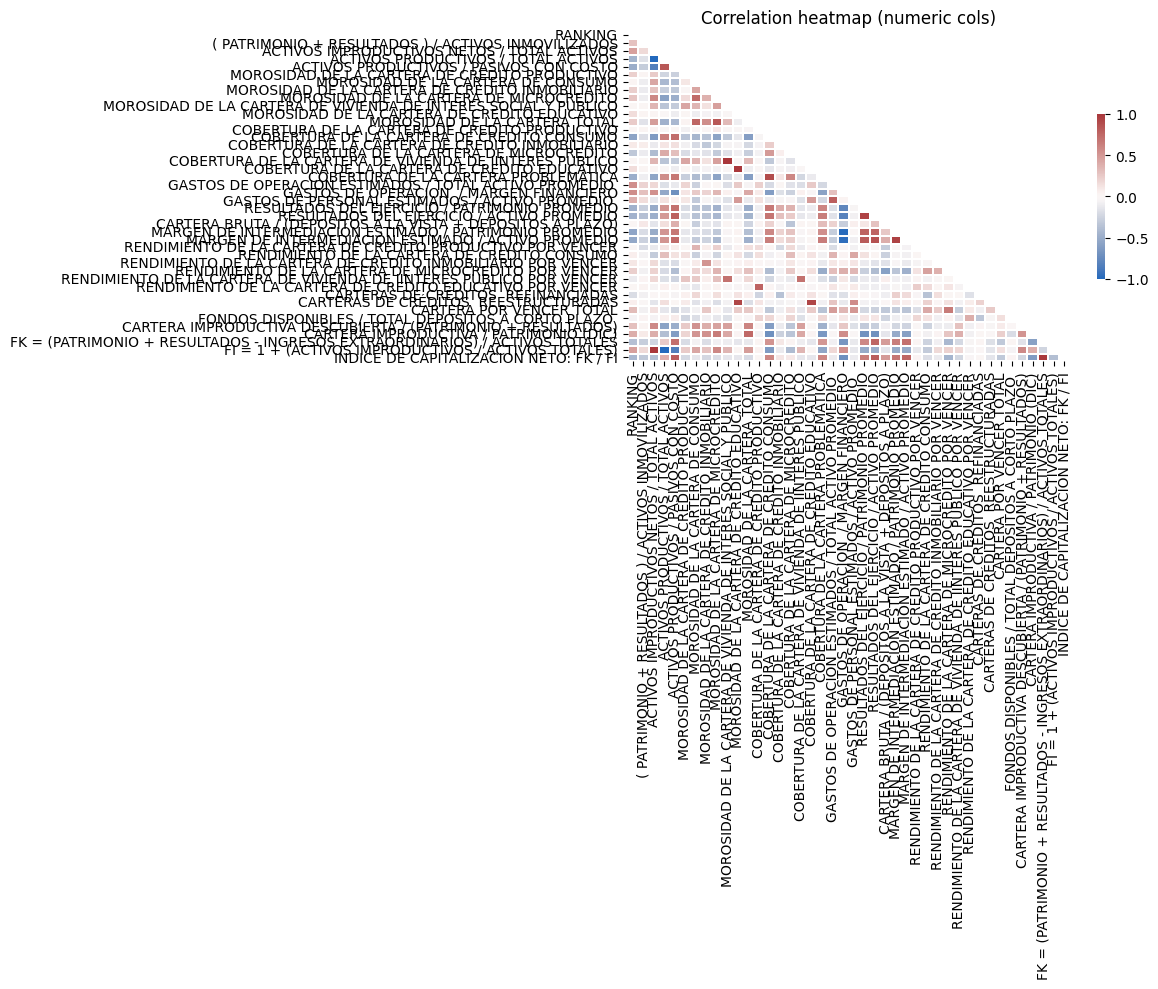

In [22]:
# 2) Correlaciones y pares de alta correlación
df_num = df[numeric_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# imputar medianas temporalmente para cálculos
df_num_filled = df_num.fillna(df_num.median())
corr = df_num_filled.corr()
# pares con |corr| alto
threshold = 0.85
corr_abs = corr.abs()
mask = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
pairs = corr_abs.where(mask).stack().sort_values(ascending=False)
high_pairs = pairs[pairs > threshold]
high_pairs_out = FIGURES / 'high_corr_pairs.csv'
high_pairs.reset_index().rename(columns={'level_0':'col1','level_1':'col2',0:'abs_corr'}).to_csv(high_pairs_out, index=False)
print('High correlation pairs saved to', high_pairs_out)
display(high_pairs.head(30))

# Heatmap de correlación (con máscara triangular)
plt.figure(figsize=(12,10))
mask2 = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask2, cmap='vlag', center=0, vmax=1, vmin=-1,
            square=False, linewidths=0.01, cbar_kws={'shrink':.5})
plt.title('Correlation heatmap (numeric cols)')
plt.tight_layout()
plt.savefig(FIGURES / 'corr_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# 3) VIF (Variance Inflation Factor)
from sklearn.linear_model import LinearRegression

def compute_vif(df_numeric):
    X = df_numeric.copy()
    # excluir columnas constantes
    const_cols = X.columns[X.std() == 0].tolist()
    if len(const_cols) > 0:
        X = X.loc[:, X.std() != 0]
    vif_results = []
    for col in X.columns:
        y = X[col].values.reshape(-1,1)
        X_others = X.drop(columns=[col]).values
        if X_others.shape[1] == 0:
            r2 = 0.0
        else:
            model = LinearRegression()
            model.fit(X_others, y)
            r2 = model.score(X_others, y)
        vif = 1.0 / (1.0 - r2) if (1.0 - r2) > 1e-12 else float('inf')
        vif_results.append((col, float(vif)))
    vif_df = pd.DataFrame(vif_results, columns=['variable','VIF']).sort_values('VIF', ascending=False).reset_index(drop=True)
    return vif_df

vif_df = compute_vif(df_num_filled)
vif_out = FIGURES / 'vif_report.csv'
vif_df.to_csv(vif_out, index=False)
print('VIF report saved to', vif_out)
display(vif_df.head(30))

VIF report saved to ../figures/vif_report.csv


,variable,VIF
0,COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERE...,inf
1,ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS,inf
2,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,inf
3,FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTA...,inf
4,MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES...,inf
5,MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO,inf
6,COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO,inf
7,INDICE DE CAPITALIZACION NETO: FK / FI,5744.508021
8,FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRA...,4802.789144
9,MARGEN DE INTERMEDIACIÓN ESTIMADO / PATRIMONIO...,1798.974843


In [24]:
# 4) Skew detection y transformaciones sugeridas (log1p/sqrt)
skews = df_num_filled.skew().dropna()
skews_sorted = skews.abs().sort_values(ascending=False)
display(skews_sorted.head(20))
skew_thresh = 1.0
to_transform = skews[skews.abs() > skew_thresh].index.tolist()
print('Columns to consider for transform (|skew|>', skew_thresh, '):', len(to_transform))

df_transformed = df_num_filled.copy()
transformation_map = {}
for col in to_transform:
    series = df_num_filled[col].astype(float).copy()
    minv = series.min()
    shift = 0.0 if minv > 0 else (-minv) + 1e-6
    series_shifted = series + shift
    # log1p (general)
    log_trans = np.log1p(series_shifted)
    log_skew = pd.Series(log_trans).skew()
    sqrt_skew = None
    if (series >= 0).all():
        sqrt_candidate = np.sqrt(series)
        sqrt_skew = pd.Series(sqrt_candidate).skew()
    # elegir la que mejore |skew|
    use_log = True
    if sqrt_skew is not None and abs(sqrt_skew) < abs(log_skew):
        df_transformed[col + '_sqrt'] = sqrt_candidate
        transformation_map[col] = 'sqrt'
    else:
        df_transformed[col + '_log1p'] = log_trans
        transformation_map[col] = 'log1p'

# guardar mapa de transformaciones
trans_map_out = FIGURES / 'transformation_map.json'
with open(trans_map_out, 'w', encoding='utf8') as f:
    json.dump(transformation_map, f, indent=2, ensure_ascii=False)
print('Transformation map saved to', trans_map_out)
print('New transformed columns:', [c for c in df_transformed.columns if c not in df_num_filled.columns][:30])

MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO         6.480741
COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO                 6.480741
COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO                            6.480741
MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO                            6.480741
COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO                           6.375921
( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS                     6.219191
CARTERAS DE CRÉDITOS  REESTRUCTURADAS                                   5.119229
RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER               4.502446
RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER    4.407529
RENDIMIENTO DE LA CARTERA DE MICROCREDITO POR VENCER                    4.223481
COBERTURA DE LA CARTERA DE MICROCREDITO                                 3.988574
CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS)            3.918924
MOROSIDAD DE LA CARTERA DE C

Columns to consider for transform (|skew|> 1.0 ): 26
Transformation map saved to ../figures/transformation_map.json
New transformed columns: ['( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS_log1p', 'ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS_sqrt', 'ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS_log1p', 'MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO_sqrt', 'MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO_sqrt', 'MOROSIDAD DE LA CARTERA DE MICROCREDITO_sqrt', 'MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO_log1p', 'MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO_sqrt', 'COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO_log1p', 'COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO_log1p', 'COBERTURA DE LA CARTERA DE MICROCREDITO_sqrt', 'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO_sqrt', 'COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO_sqrt', 'COBERTURA DE LA CARTERA PROBLEMÁTICA_log1p', 'RESULTADOS DEL EJERCICIO / ACTIVO PROMEDIO_log1p', 'CARTERA BRUTA / (DEPOSITOS A LA VISTA + 

In [25]:
# 4.5) Limpieza mínima de columnas y sincronización de transformation_map
# Normalizar nombres: strip y colapsar espacios múltiples
df.columns = df.columns.map(lambda c: c.strip() if isinstance(c, str) else c)
df.columns = df.columns.map(lambda c: ' '.join(c.split()) if isinstance(c, str) else c)
print('Columnas normalizadas (ejemplo):', list(df.columns)[:10])

# Detectar nombres duplicados
dup_names = df.columns[df.columns.duplicated()].unique().tolist()
if dup_names:
    print('Duplicated column names:', dup_names)

# Detectar columnas idénticas (mismo contenido)
def find_identical_columns(df_check):
    identical = []
    cols = list(df_check.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            c1, c2 = cols[i], cols[j]
            try:
                if df_check[c1].equals(df_check[c2]):
                    identical.append((c1, c2))
            except Exception:
                continue
    return identical

ident = find_identical_columns(df)
print('Identical column pairs found:', len(ident))
if len(ident) > 0:
    # eliminar la segunda columna de cada par
    to_drop = sorted({b for a,b in ident})
    print('Dropping identical columns:', to_drop)
    df.drop(columns=to_drop, inplace=True)

# Recalcular columnas numéricas
numeric_cols = detect_numeric_cols(df)
print('Numeric cols after cleanup:', len(numeric_cols))

# Sincronizar transformation_map si existe
if 'transformation_map' in globals():
    missing = [c for c in list(transformation_map.keys()) if c not in df.columns]
    if missing:
        print('Warning: transformation_map has columns not in df:', missing)
        # intentar mapear por nombre normalizado (case-insensitive)
        cols_norm = {c.lower().strip(): c for c in df.columns}
        new_map = {}
        unmapped = []
        for c, v in transformation_map.items():
            key = c.lower().strip()
            if key in cols_norm:
                new_map[cols_norm[key]] = v
            else:
                key2 = ' '.join(c.split()).lower()
                if key2 in cols_norm:
                    new_map[cols_norm[key2]] = v
                else:
                    unmapped.append(c)
        if unmapped:
            print('Could not map these transformation_map columns to dataframe:', unmapped)
        transformation_map = new_map
        # guardar mapa actualizado
        try:
            trans_map_out = FIGURES / 'transformation_map.json'
            with open(trans_map_out, 'w', encoding='utf8') as f:
                json.dump(transformation_map, f, indent=2, ensure_ascii=False)
            print('Updated transformation_map saved to', trans_map_out)
        except Exception as e:
            print('Could not save updated transformation_map:', e)


Columnas normalizadas (ejemplo): ['INSTITUCIÓN', 'SEGMENTO', 'CALIFICADORA', 'CALIFICACIÓN', 'RANKING', '( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS', 'ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO', 'MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO']
Identical column pairs found: 1
Dropping identical columns: ['COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO']
Numeric cols after cleanup: 41
Could not map these transformation_map columns to dataframe: ['COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO']
Updated transformation_map saved to ../figures/transformation_map.json


Outlier summary saved to ../figures/outlier_summary.csv


,variable,n_obs,outliers_IQR,outliers_zscore
0,CARTERAS DE CRÉDITOS REESTRUCTURADAS,42,11,1
1,CARTERAS DE CRÉDITOS REFINANCIADAS,42,9,0
2,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO...,42,8,1
3,COBERTURA DE LA CARTERA PROBLEMÁTICA,42,7,2
4,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,42,6,0
5,ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS,42,6,0
6,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,42,6,0
7,FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTA...,42,6,0
8,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILI...,42,6,1
9,COBERTURA DE LA CARTERA DE MICROCREDITO,42,6,1


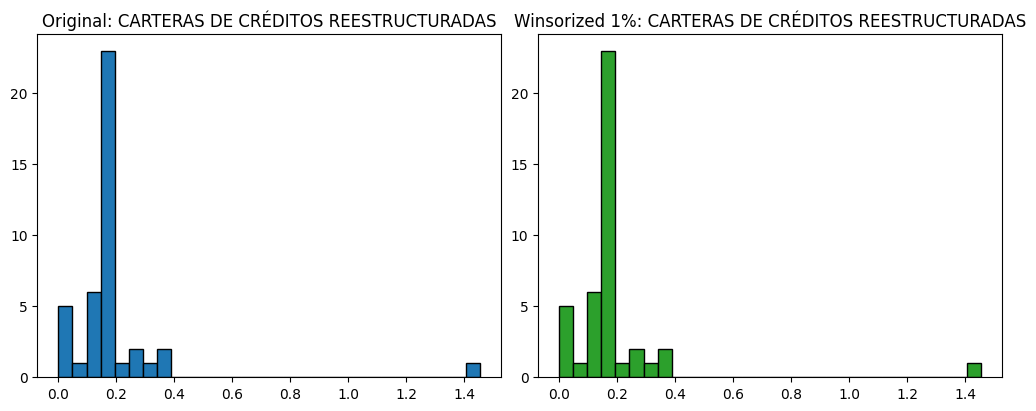

In [26]:
# 5) Outliers: resumen por IQR y z-score + winsorize demo
from scipy import stats
from scipy.stats.mstats import winsorize

# Asegurarse de que df_num está sincronizado con numeric_cols (después de limpieza)
df_num = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

outlier_summary = []
for col in df_num.columns:
    s = df_num[col]
    s_nonna = s.dropna()
    if s_nonna.shape[0] < 5:
        outlier_summary.append((col, s_nonna.shape[0], 0, 0))
        continue
    q1 = s_nonna.quantile(0.25)
    q3 = s_nonna.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    iqr_flags = ((s < lower) | (s > upper)).sum()
    # zscore sobre valores no-na
    z_flags = (np.abs(stats.zscore(s_nonna, nan_policy='omit')) > 3).sum()
    outlier_summary.append((col, s_nonna.shape[0], int(iqr_flags), int(z_flags)))

outlier_df = pd.DataFrame(outlier_summary, columns=['variable','n_obs','outliers_IQR','outliers_zscore']).sort_values('outliers_IQR', ascending=False).reset_index(drop=True)
outlier_out = FIGURES / 'outlier_summary.csv'
outlier_df.to_csv(outlier_out, index=False)
print('Outlier summary saved to', outlier_out)
display(outlier_df.head(20))

# winsorize demo en la variable con más outliers_IQR
top_vars = outlier_df.loc[outlier_df['outliers_IQR']>0, 'variable'].tolist()[:6]
if len(top_vars) > 0:
    demo_col = top_vars[0]
    s_orig = df_num[demo_col].dropna()
    s_w = winsorize(s_orig, limits=(0.01,0.01))
    fig, ax = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)
    ax[0].hist(s_orig, bins=30, color='C0', edgecolor='k')
    ax[0].set_title(f'Original: {demo_col}')
    ax[1].hist(s_w, bins=30, color='C2', edgecolor='k')
    ax[1].set_title(f'Winsorized 1%: {demo_col}')
    plt.savefig(FIGURES / 'outlier_winsor_demo.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No hay variables con outliers IQR detectados para demo')


In [27]:
# 6) Pipeline reproducible (esqueleto) y guardado
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
import joblib

# ejemplo: aplicar PowerTransformer a columnas sesgadas y scaler al resto
power_cols = [c for c,v in transformation_map.items() if v == 'log1p'] if 'transformation_map' in globals() else []
# si no hay power_cols, aplicamos PowerTransformer al conjunto completo numérico como fallback
if len(power_cols) == 0:
    power_cols = numeric_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num_power', PowerTransformer(method='yeo-johnson'), power_cols),
        ('num_scale', StandardScaler(), numeric_cols)
    ], remainder='drop', sparse_threshold=0
)
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('pre', preprocessor)
] )

# Fit pipeline (puede tardar si hay muchas columnas)
try:
    df_num_for_fit = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    pipe.fit(df_num_for_fit)
    joblib.dump(pipe, MODELS / 'preprocess_pipeline.joblib')
    print('Pipeline fitted and saved to', MODELS / 'preprocess_pipeline.joblib')
except Exception as e:
    print('No se pudo fit el pipeline automáticamente:', e)
    print('Puedes ajustar manualmente las columnas en `power_cols` y volver a ejecutar')

No se pudo fit el pipeline automáticamente: Specifying the columns using strings is only supported for dataframes.
Puedes ajustar manualmente las columnas en `power_cols` y volver a ejecutar


In [28]:
# 7) Transformar y guardar dataset procesado (numérico)
try:
    pipe = joblib.load(MODELS / 'preprocess_pipeline.joblib')
    df_num_for_transform = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    X_proc = pipe.transform(df_num_for_transform)
    # Column names: ColumnTransformer drops names — aquí usamos numeric_cols orden como referencia
    proc_df = pd.DataFrame(X_proc, columns=[f'num_{i}' for i in range(X_proc.shape[1])])
    # concatenar columnas no numéricas útiles (id, name, rating) si existen
    meta_cols = [c for c in ['id','nombre', rating_col] if c in df.columns]
    out_df = pd.concat([df[meta_cols].reset_index(drop=True), proc_df.reset_index(drop=True)], axis=1)
    out_path = DATA_RAW / 'cooperativas_segmento1_completo_final_processed.csv'
    out_df.to_csv(out_path, index=False)
    print('Processed dataset saved to', out_path)
except Exception as e:
    print('No se pudo transformar y guardar dataset procesado:', e)
    print('Asegúrate de haber fit el pipeline en la celda anterior')

No se pudo transformar y guardar dataset procesado: [Errno 2] No such file or directory: '../models/preprocess_pipeline.joblib'
Asegúrate de haber fit el pipeline en la celda anterior


**Siguientes pasos recomendados (resumen rápido):**
- Revisar `figures/vif_report.csv` y `figures/high_corr_pairs.csv` para decidir eliminación/combinación de variables.
- Ajustar `power_cols` si las transformaciones automáticas no son las ideales.
- Implementar selección final de features (por ejemplo `VarianceThreshold` o selección basada en importancia de un RandomForest).
- Ejecutar clustering (KMeans, Agglomerative, DBSCAN) sobre `cooperativas_segmento1_completo_final_processed.csv` y guardar resultados en `figures/`.
- Implementar protocolo semisupervisado en un notebook/escript `src/semisupervised_experiments.py`.

Si quieres, puedo: (A) ajustar este notebook para tu esquema de columnas exactas, (B) crear `src/preprocess.py` con funciones reutilizables y tests, o (C) generar los scripts para ejecutar los experimentos semisupervisados.